# Sieve Jobs
As I prepare to enter the Data Science industry, I thought it would be great practice to use some of the tools I've learned to apply to the job search itself. You could say this is an attempt to kill two birds with one stone.

## Objective
The objective of this study is to identify the entry level data science jobs by applying natural language processing libraries to the descriptions given in the job postings page of the linkedin website. At the time of this writing, there are over 155,000 jobs listed on the website in the Los Angeles area. While in terms of machine learning it might be beneficial to have a larger dataset, since I will be scraping the jobs individually, I will be limiting the jobs to those posted in the past week in the Los Angeles area that contains the keyword 'data' which still amounts to close to 5000 postings.

### I. Gather jobs data
For the purposes of this project, I am going to use the jobs section of the linkedin website. To keep the jobs shown as clean as possible (without any bias from my linkedin profile), I will be searching jobs as a guest and scraping all jobs posted within the past week. 

#### Import packages

In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import pandas_profiling
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
%matplotlib inline
import seaborn as sns
from IPython.display import HTML
import numpy as np
import spacy
import re
from collections import Counter
from wordcloud import WordCloud
from PIL import Image

!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/site-packages/en_core_web_sm -->
/usr/local/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


#### Utility Functions

In [2]:
########################### get webpage ############################
def simple_get(url):
    
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_resp(resp):
                return resp.content
            else:
                return None
            
    except RequestException as e:
        log_error(f'Error during requsts to {url}: {str(e)}')
        return None
    
def is_good_resp(resp):
    
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200
            and content_type is not None
            and content_type.find('html') > -1)

def log_error(e):
    
    print(e)

###################### parse with BeautifulSoup ##################### 

# parse html with BeautifulSoup
def bsparser(url):
    
    # get page
    raw_html = simple_get(url)

    # parse using BeautifulSoup
    parsed_html = BeautifulSoup(raw_html, 'html.parser')
    
    return parsed_html

##################### gather job info from page #####################

# scrape each job post page for relevant information
def sieve_page(html):
    
    # find all job listing titles
    job_list = html.find_all(class_='result-card job-result-card result-card--with-hover-state')
    #print(job_list)

    page_list = []
    
    if len(job_list) > 0:
        for job in job_list:
            global COUNT
            COUNT += 1
            print(f'Scraping job #{COUNT}\r', end='')
            
            title = job.find('h3').text
            company = job.find('h4').text
            location = job.find(class_='job-result-card__location').text
            link = job.find(class_='result-card__full-card-link').get('href')
            description = get_description(link)
            
            sieved_job = [title, company, location, link] + description
            page_list.append(sieved_job)
            
        #print(len(page_list))
        
        return page_list
    else:
        return None
    
#################### get full job description ######################  
    
# get details of the job posting
def get_description(url):
    details = []
    
    job_page = BeautifulSoup(simple_get(url), 'html.parser')
    level = job_page.find(class_='job-criteria__text job-criteria__text--criteria').text
    description = job_page.find(class_='description__text description__text--rich').text
    
    details = [level, description]
    
    return details

######################### keep count of jobs########################

COUNT = 0

###################### scrape all pages ############################

# takes the total number of jobs to scrape as the argument
def sieve_all_pages(url, desired_num_of_jobs):
    global COUNT
    COUNT = 0
    
    # start timer
    start = time.time()
    
    # used as a search parameter since each page only displays 25 posts
    list_pos = 0          
    sieved_list = []
    bad_urls = []
        
    while list_pos < desired_num_of_jobs:
        
        try:
            # get and parse page
            url += f'&start={list_pos}'
            html = bsparser(url)

            # use sieve_page function to gather relevant data and add to main list
            new_list = sieve_page(html)

            if len(new_list) > 0:
                sieved_list += new_list
                count = len(sieved_list)
            else:
                print(f'It took {time.time() - start} seconds to scrape {count} jobs.')
                break
                
        except:
            # handle error
            bad_urls.append(url)
            pass
        
        # change to new position
        list_pos += 25

    print(f'It took {time.time() - start} seconds to scrape {count} jobs.')

    return sieved_list

#### Scrape desired number of jobs

In [66]:
url = 'https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=data&location=Los%20Angeles%20Metropolitan%20Area&trk=guest_job_search_jobs-search-bar_search-submit&redirect=false&position=1&pageNum=0&f_TP=1%2C2'

# let's get scraping. This might take a few minutes.
my_jobs = sieve_all_pages(url, 5000)

It took 2502.3592681884766 seconds to scrape 4975 jobs.


### II. Build Dataframe and Cursory Exploration

#### Build dataframe

In [67]:
df = pd.DataFrame(my_jobs, columns=['title', 'company', 'location', 'link', 'level', 'description'])
df.sample(1)


title company                                       location  \
2219  Data Engineer  Prosum  91364, Los Angeles, California, United States   

                                                   link             level  \
2219  https://www.linkedin.com/jobs/view/data-engine...  Mid-Senior level   

                                            description  
2219  We are seeking a Senior ETL Developer to join ...

In [68]:
df.shape

(4975, 6)

In [69]:
profile = df.profile_report()

In [70]:
profile

#### Initial Analysis and Cleaning

What I am most interested in is whether the position is one that I have prepared for. I want to apply to positions that gives me the best chance of being hired. First, we need to filter out all non-data science jobs. But before we do that, just looking at the sample of job listings, the job titles don't seem to have any type of format. We need to fix that. Instead of changing the title itself, let's add a column that shows whether the job is a job in data science.

In [72]:
# create a new column 'is_ds' to indicate whether the job is related to data science
# 'Data Scien' will catch both data science and data scientist
df['ds'] = np.where(df['title'].str.contains('Data Scien|Machine Learning'), True, False)
df.sample(5)

title                     company  \
2951           Data Engineer                     Clutter   
3567  Data Control Associate  Interactive Resources - iR   
2354           Data Engineer                      Prosum   
445     Senior Data Engineer   Chrome River Technologies   
4816          Data Scientist                     Harnham   

                                           location  \
2951                            Los Angeles, CA, US   
3567     91107, Pasadena, California, United States   
2354  91364, Los Angeles, California, United States   
445          Los Angeles, California, United States   
4816                  Los Angeles Metropolitan Area   

                                                   link             level  \
2951  https://www.linkedin.com/jobs/view/data-engine...       Entry level   
3567  https://www.linkedin.com/jobs/view/data-contro...         Associate   
2354  https://www.linkedin.com/jobs/view/data-engine...  Mid-Senior level   
445   https://www.linkedin.com/jobs/view/senior-data...  Mid-Senior level   
4816  https://www.linkedin.com/jobs/view/data-scient...  Mid-Senior level   

                                            description     ds  
2951  Clutter is an on-demand storage and technology...  False  
3567  MUST have Banking, Finance, Data Entry experie...  False  
2354  We are seeking a Senior ETL Developer to join ...  False  
445   There's something in the water at Chrome River...  False  
4816  MACHINE LEARNING ENGINEER $175,000 + BENEFITS ...   True

Since the initial search was for any job that had the word 'data' in its title, if it's not explicitly labeled 'Data Scientist' or contain the phrase 'machine learning',  these will go into a third category 'other.' These job listings will have to be classified using our model.

In [73]:
# create another column 'maybe_ds'
df['da'] = np.where(df['title'].str.contains('Data Analys'), True, False)
df.sample(5)

title                company  \
3338  Sales Data Analyst                   Hulu   
765       Data Scientist  Tangerine Search Inc.   
3796        Data Analyst        Relevante, Inc.   
889         Data Analyst                  Quibi   
150         Data Analyst          Real Staffing   

                                     location  \
3338                     Santa Monica, CA, US   
765       Pasadena, California, United States   
3796                       Sun Valley, CA, US   
889                       Los Angeles, CA, US   
150   San Fernando, California, United States   

                                                   link             level  \
3338  https://www.linkedin.com/jobs/view/sales-data-...    Not Applicable   
765   https://www.linkedin.com/jobs/view/data-scient...  Mid-Senior level   
3796  https://www.linkedin.com/jobs/view/data-analys...       Entry level   
889   https://www.linkedin.com/jobs/view/data-analys...       Entry level   
150   https://www.linkedin.com/jobs/view/data-analys...         Associate   

                                            description     ds     da  
3338  Hulu is the leading premium streaming service ...  False   True  
765   Machine Learning Engineer and Data Scientist W...   True  False  
3796  Salary: $81,000We have partnered with a large ...  False   True  
889   What's Quibi?Launching next year, Quibi is the...  False   True  
150   A world leading Medical Device Company in Sylm...  False   True

In [74]:
# Data Science position count
ds_cts = df['ds'].value_counts()
ds_cts

False    4198
True      777
Name: ds, dtype: int64

In [75]:
# Data Analyst position count
da_cts = df['da'].value_counts()
da_cts

False    2503
True     2472
Name: da, dtype: int64

In [76]:
# let's check for any overlap in between the two titles
df[(df['ds']==True) & (df['da']==True)].count()

title          0
company        0
location       0
link           0
level          0
description    0
ds             0
da             0
dtype: int64

This is a good sign. Since the way we split the two categories was just by checking to see whether the title contained certain words, at least we won't have to worry about jobs that have both titles, hence, making it easier for us to classify. 

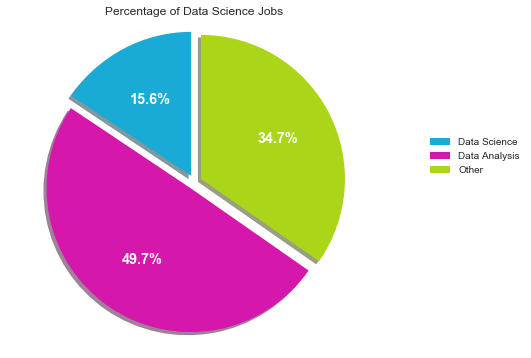

In [83]:
# plot pie chart
labels = ['Data Science', 'Data Analysis', 'Other']
# [ds count, da count, other]
sizes = [ds_cts.tolist()[1],
         da_cts.tolist()[1],
         ds_cts.tolist()[0]-da_cts.tolist()[1]
        ]

f, ax = plt.subplots(figsize=(6, 6))
text_dict = {'color' : 'w', 
             'size'  : 'x-large', 
             'weight': 'bold'}
colors = ['#18ABD5', '#D518AB', '#ABD518']

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True,
       textprops=text_dict, colors=colors, explode=[0.05, 0.05, 0.05])
ax.axis('equal')

plt.title('Percentage of Data Science Jobs')
plt.legend(loc=4, bbox_to_anchor=(1, 0.5, 0.5, 0.5))
plt.show()

Although the ratio could change from day to day (since we are only taking jobs listed in the past week), as of this last scrape, it looks like DS-titled job listings are outnumbered at a 3:1 ratio with Data Analysis jobs. So, we will randomly sample the data analysis jobs equalize it with the data science jobs.

Once I have balanced classes, what I will be doing is building an accurate model that differentiates the DS jobs from DA jobs and apply it to the other listings to classify them. This dataset actually works pretty nicely for that purpose. I can train the model on the rest of the data that is clearly classified as DS jobs and DA jobs which amounts to about 60% of the jobs listed. Then I can use that model to classify the other jobs. Sounds like a plan!

In [100]:
df.columns

Index(['title', 'company', 'location', 'link', 'level', 'description', 'ds',
       'da', 'parsed', 'filtered'],
      dtype='object')

#### Data Preparation for NLP
For this model, the target variable will be the is_ds column and I will be using the spacy library to parse the descriptions for each of the jobs. Then I am going to employ Bag of Words to create the features set on which the model will be trained.

In [86]:
df.iloc[3851].description

"Hulu is the leading premium streaming service offering live and on-demand TV and movies, with and without commercials, both in and outside the home. Operating at the intersection of entertainment and technology, Hulu has a unique opportunity to be the number one choice for TV. We captivate and connect viewers with the stories they love, and we’re looking for people who are passionate about redefining TV through innovation, unconventional thinking, and embracing fun. Join us and see what Hulugan life is all about.SummaryHulu’s Ad Sales Analytics team is seeking a Sales Data Analyst who will be an exceptional addition to our growing team. As a Sales Data Analyst at Hulu, you are responsible for the accuracy, exposure and maintenance of account-based data and relationships throughout our Ad Sales tools. The right person for this role is a highly motivated problem-solver who is comfortable interpreting large data sets and communicating results throughout a sales organization. If you are s

In [87]:
nlp = spacy.load('en')

In [ ]:
#df = df.drop(columns=['parsed'])
#df.columns

In [88]:
# text cleaner
def clean_text(desc):
    desc = desc.lower()
    desc = re.sub('[\(\)]', '', desc)
    desc = re.sub('[\/\-\.]', ' ', desc)
    desc = ' '.join(desc.split())
    return desc

# parse each of the descriptions using spaCy
def spacify(desc):
    return nlp(clean_text(desc))

# filter out puctuation and stop words
def filter_text(parsed_text):
    filtered = []
    for token in parsed_text:
        if not token.is_punct and not token.is_stop:
            filtered.append(token.lemma_)
        
    return filtered 


In [89]:
# first parse each cleaned job description then filter lemmas
df['parsed'] = df.apply(lambda row: spacify(row['description']), axis=1)
df['filtered'] = df.apply(lambda row: filter_text(row['parsed']), axis=1)

Let's now sample the DA jobs to balance out the classes.

In [101]:
da_df = df[df['da'] == True].sample(ds_cts.tolist()[1])
da_df.sample(5)

title          company  \
3112  Marketing Data Analyst       AuditBoard   
1846            Data Analyst  Relevante, Inc.   
4549     Senior Data Analyst            DISQO   
538       Sales Data Analyst             Hulu   
2174     Senior Data Analyst            DISQO   

                                    location  \
3112           Los Angeles Metropolitan Area   
1846                      Sun Valley, CA, US   
4549  Los Angeles, California, United States   
538                     Santa Monica, CA, US   
2174  Los Angeles, California, United States   

                                                   link             level  \
3112  https://www.linkedin.com/jobs/view/marketing-d...  Mid-Senior level   
1846  https://www.linkedin.com/jobs/view/data-analys...       Entry level   
4549  https://www.linkedin.com/jobs/view/senior-data...  Mid-Senior level   
538   https://www.linkedin.com/jobs/view/sales-data-...    Not Applicable   
2174  https://www.linkedin.com/jobs/view/senior-data...  Mid-Senior level   

                                            description     ds    da  \
3112  AuditBoard Ranked #3 on Deloitte’s 2019 Fast 5...  False  True   
1846  Salary: $81,000We have partnered with a large ...  False  True   
4549  DISQO is a next-generation consumer insights p...  False  True   
538   Hulu is the leading premium streaming service ...  False  True   
2174  DISQO is a next-generation consumer insights p...  False  True   

                                                 parsed  \
3112  (auditboard, ranked, #, 3, on, deloitte, ’s, 2...   
1846  (salary, :, $, 81,000we, have, partnered, with...   
4549  (disqo, is, a, next, generation, consumer, ins...   
538   (hulu, is, the, leading, premium, streaming, s...   
2174  (disqo, is, a, next, generation, consumer, ins...   

                                               filtered  
3112  [auditboard, rank, 3, deloitte, 2019, fast, 50...  
1846  [salary, $, 81,000we, partner, large, mining, ...  
4549  [disqo, generation, consumer, insight, platfor...  
538   [hulu, lead, premium, streaming, service, offe...  
2174  [disqo, generation, consumer, insight, platfor...

In [102]:
da_df.shape

(777, 10)

In [104]:
ds_df = df[df['ds'] == True]
ds_df.shape

(777, 10)

In [147]:
# combine the two dfs
bal_df = da_df.append(ds_df, ignore_index=True)
bal_df.head(5)

title                     company                      location  \
0  Data Analyst                      Ejento           Los Angeles, CA, US   
1  Data Analyst         3 Phases Renewables  90245 El Segundo, California   
2  Data Analyst  AIDS Healthcare Foundation           Los Angeles, CA, US   
3  Data Analyst                      Ejento           Los Angeles, CA, US   
4  Data Analyst                     System1                Venice, CA, US   

                                                link           level  \
0  https://www.linkedin.com/jobs/view/data-analys...     Entry level   
1  https://www.linkedin.com/jobs/view/data-analys...  Not Applicable   
2  https://www.linkedin.com/jobs/view/data-analys...     Entry level   
3  https://www.linkedin.com/jobs/view/data-analys...     Entry level   
4  https://www.linkedin.com/jobs/view/data-analys...     Entry level   

                                         description     ds    da  \
0  One of my best clients is looking to hire a Da...  False  True   
1  3 Phases Renewables is a growing company in th...  False  True   
2  Who We AreAMAZING INDIVIDUALS WORKING FOR POSI...  False  True   
3  One of my best clients is looking to hire a Da...  False  True   
4  System1 is looking for a driven Data Analyst. ...  False  True   

                                              parsed  \
0  (one, of, my, best, clients, is, looking, to, ...   
1  (3, phases, renewables, is, a, growing, compan...   
2  (who, we, areamazing, individuals, working, fo...   
3  (one, of, my, best, clients, is, looking, to, ...   
4  (system1, is, looking, for, a, driven, data, a...   

                                            filtered  
0  [good, client, look, hire, data, analyst, los,...  
1  [3, phase, renewable, grow, company, renewable...  
2  [areamaze, individual, work, positive, people,...  
3  [good, client, look, hire, data, analyst, los,...  
4  [system1, look, drive, datum, analyst, member,...

In [148]:
bal_df.shape

(1554, 10)

#### Bag of Words
Now let's create a bag of words consisting of the most frequently used words.

In [115]:
# get most common words
def bag_of_words(text, size):
    all_words = []
    rows = []
    words_df = pd.DataFrame(columns=['checkpoint', 'word', 'count'])

    for i, doc in enumerate(text.tolist()):
        
        # create a dataframe with word counts at an interval
        if i > 0 and i % 25 == 0 or i == len(text.tolist()):  # checkpoint every 25 rows
            top_words = Counter(all_words).most_common(25)
            
            for item in top_words:
                rows.append([i, item[0], item[1]])
                
        else:
            pass
        
        # bag of words
        for token in doc:
            if not token.is_punct and not token.is_stop:
                all_words.append(token.lemma_)
        
        bow = [item[0] for item in Counter(all_words).most_common(size)]
        
    return rows, bow   


In [116]:
# let's get top 500 and top 1000 to see which gets us better models
top500, top500_bow = bag_of_words(bal_df.parsed, 500)
#top1000_df, top1000_bow = bag_of_words(df.parsed, 1000)

In [131]:
# create dataframe with the counts checkpoint data
word_df = pd.DataFrame(top500, columns=['checkpoint', 'word', 'count'])
#word_df.loc[100:200]

Let's see the word counts of the top 25 words at each checkpoint.

In [133]:
# assign colors to each word
colors = []
for i in range(100):
    colors.append(np.random.rand(3,))
        
# assign colors
c_dict = dict(zip(top500_bow[:100], colors))
#print(c_dict)

In [135]:
# function for animator
def draw_barchart(checkpoint):
    
    # get corresponding data for each checkpoint
    cp_df = word_df[word_df['checkpoint']==checkpoint].sort_values(by='count', ascending=True)
    
    # clear axis
    ax.clear()
    
    # draw new plot
    ax.barh(cp_df['word'], cp_df['count'], color=[c_dict[x] for x in cp_df['word']], alpha=0.5)
    
    dx = cp_df['count'].max()/200
    
    # iterate over the values to plot labels and values
    for i, (count, word) in enumerate(zip(cp_df['count'], cp_df['word'])):
        ax.text(count-dx, i, word, ha='right', va='center', fontsize=15, weight=1000)
        ax.text(count+dx, i, count, ha='left', va='center', fontsize=15)
    
    ax.xaxis.set_ticks_position('top')
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.text(0, 1.05, 'Top 25 words used by count', transform=ax.transAxes, size=25, weight=1000)
    ax.text(1, 0.4, f"Checkpoint: {checkpoint}", transform=ax.transAxes, size=46, ha='right')
    ax.grid(b=True, which='major', axis='x', color='grey')
    ax.set_axisbelow(True)
    ax.set_facecolor('white')
    plt.close()

#draw_barchart(200)

# animate
f, ax = plt.subplots(figsize=(14, 12))
animator = animation.FuncAnimation(f, draw_barchart, frames=range(25, bal_df.shape[0], 25),
                                   interval=200)
HTML(animator.to_jshtml())



Well that wasn't much of a race, per se. Top 10 words pretty much stay the same understandably. Now let's go ahead and create the feature set using the bag of words.

### III. Feature Engineering

In [144]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(df, common_words):
    
    # start timer
    start = time.time()
    
    # Scaffold the data frame and initialize counts to zero.
    this_df = pd.DataFrame(columns=common_words)
    this_df['description'] = df['parsed']
    this_df['ds'] = df['ds']
    this_df['da'] = df['da']
    this_df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['description']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in nlp(sentence)
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            this_df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 1000 == 0:
            print("Processing row {}".format(i))
        
    print(f'Time elapsed: {(time.time()-start):0.2f}s')

    return this_df

In [149]:
# get new df with only the dependent and independent variables
feature_df = bow_features(bal_df, top500_bow)    # this should take a while

Processing row 0
Processing row 1000
Time elapsed: 196.32s


In [150]:
feature_df.sample(5)

datum  experience  work  data  team  learning  business  machine  \
643       8           3     1     5     3         1         5        0   
742       7           3     3     2     4         0         0        0   
1148     16           6     4     5     4         5         0        4   
1278      2           6     5     0     1         4         3        5   
1407     13           8     5     2     3         4         5        2   

      analysis  skill  ...  venture  locate  campus  assurance  add  usage  \
643          3      2  ...        0       0       0          0    0      0   
742          1      0  ...        0       0       0          0    0      0   
1148         3      1  ...        0       1       1          1    0      1   
1278         1      3  ...        1       0       0          0    0      0   
1407         2      3  ...        0       0       0          0    0      1   

      wrangle                                        description     ds     da  
643         2  (about, dsc, :, we're, on, a, mission, to, hel...  False   True  
742         0  (3, phases, renewables, is, a, growing, compan...  False   True  
1148        0  (age, of, learning, is, looking, for, several,...   True  False  
1278        0  (machine, learning, engineer, $, 175,000, +, b...   True  False  
1407        0  (tamara, mellon, ,, co, founder, of, jimmy, ch...   True  False  

[5 rows x 503 columns]

That looks good. Now for some modeling, finally!

### IV. Train Models

#### Training and Testing data split
If you recall, we were going to model the data using job listings that were clearly DS (Data Science) or DA jobs. Then we are going to use that trained model on classifying the 'other' jobs.

In [152]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

y = feature_df['ds']
X = feature_df.drop(['ds', 'da', 'description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')


Train set size: (932, 500)
Test set size: (622, 500)


#### Modeling function

In [153]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# I'm going to be repeating a lot of the fitting and predicting and scoring.
# Let's build a function, albeit a very limited one that does not take in additional
# hyperparameters
def classify(alg, X, y):
        
    # data formatting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=26)
    
    start = time.time()
    
    if alg == 'naive_bayes':
        clf = BernoulliNB()
        
    elif alg == 'logistic_regression':
        clf = LogisticRegression(solver='lbfgs') 
        
    elif alg == 'knn':
        clf = KNeighborsClassifier(n_neighbors=2) 
        
    elif alg == 'random_forest':
        clf = ensemble.RandomForestClassifier() 
        
    elif alg == 'svc':
        clf = SVC(gamma='auto') 
        
    elif alg == 'gradient_boost':
        clf = ensemble.GradientBoostingClassifier() 
        
    clf.fit(X_train, y_train)
    train_score = float(f'{clf.score(X_train, y_train):.4f}')
    y_pred = clf.predict(X_test)
    c_mat = confusion_matrix(y_test, y_pred, labels=[True, False])
    test_score = float(f'{clf.score(X_test, y_test):.4f}')
    elapsed = float(f'{time.time() - start:.4f}')
    
    return [train_score, test_score, elapsed], c_mat, clf
        

#### Naive-Bayes

In [154]:
nb_stats, nb_cmat, nb = classify('naive_bayes', X, y)
rows = []
rows.append(nb_stats)
rows

[[0.9936, 0.9871, 0.039]]

#### Rinse and Repeat (Logistic Regression, KNN, Random Forest, SVM, Gradient Boost)

In [155]:
lr_stats, lr_cmat, lr = classify('logistic_regression', X, y)
rows.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X, y)
rows.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X, y)
rows.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X, y)
rows.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X, y)
rows.append(gb_stats)

rows

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[0.9936, 0.9871, 0.039],
 [1.0, 0.9984, 0.0292],
 [1.0, 0.9952, 0.4003],
 [1.0, 0.9952, 0.0269],
 [1.0, 0.9984, 0.1101],
 [1.0, 1.0, 0.338]]

In [156]:
# results dataframe
res_df = pd.DataFrame(rows,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res_df

train_score  test_score  time_elapsed
Naive-Bayes               0.9936      0.9871        0.0390
Logistic Regression       1.0000      0.9984        0.0292
Random Forest             1.0000      0.9952        0.4003
KNN                       1.0000      0.9952        0.0269
SVM                       1.0000      0.9984        0.1101
Gradient Boost            1.0000      1.0000        0.3380

It's quite obvious that the bag of words with top 500 words may be overkill, especially since it takes a long time for that list to be created. Let's see if we can get good accuracy with a smaller bag. Since the bag of words is already ordered most frequent to least frequent, we can just use a subset of the top 500 list.

In [157]:
top250_bow = top500_bow[:250]
top100_bow = top500_bow[:100]
top25_bow = top500_bow[:25]

#### 250-word BOW

In [158]:
ftr_250_df = bow_features(bal_df, top250_bow)    # this should take a while

Processing row 0
Processing row 1000
Time elapsed: 172.94s


In [161]:
y250 = ftr_250_df['ds']
X250 = ftr_250_df.drop(['ds', 'da', 'description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X250, y250, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')

X_train.sample()

Train set size: (932, 250)
Test set size: (622, 250)


datum  experience  work  data  team  learning  business  machine  \
1332     16           6     4     5     4         5         0        4   

      analysis  skill  ...  share  compensation  culture  successful  leader  \
1332         3      1  ...      1             0        0           0       0   

      building  brand  desire  bachelor  trend  
1332         1      1       1         0      0  

[1 rows x 250 columns]

In [162]:
rows250 = []

nb_stats, nb_cmat, nb = classify('naive_bayes', X250, y250)
rows250.append(nb_stats)

lr_stats, lr_cmat, lr = classify('logistic_regression', X250, y250)
rows250.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X250, y250)
rows250.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X250, y250)
rows250.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X250, y250)
rows250.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X250, y250)
rows250.append(gb_stats)

rows250

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[1.0, 1.0, 0.0187],
 [1.0, 0.9984, 0.0241],
 [1.0, 0.9952, 0.2153],
 [1.0, 1.0, 0.0165],
 [1.0, 0.9984, 0.0402],
 [1.0, 1.0, 0.1932]]

In [163]:
# results dataframe
res250_df = pd.DataFrame(rows250,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res250_df

train_score  test_score  time_elapsed
Naive-Bayes                  1.0      1.0000        0.0187
Logistic Regression          1.0      0.9984        0.0241
Random Forest                1.0      0.9952        0.2153
KNN                          1.0      1.0000        0.0165
SVM                          1.0      0.9984        0.0402
Gradient Boost               1.0      1.0000        0.1932

#### 100-word BOW

In [164]:
ftr_100_df = bow_features(bal_df, top100_bow)    # this should take a while

Processing row 0
Processing row 1000
Time elapsed: 147.83s


In [166]:
y100 = ftr_100_df['ds']
X100 = ftr_100_df.drop(['ds', 'da', 'description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X100, y100, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')

#X_train.columns


Train set size: (932, 100)
Test set size: (622, 100)


In [167]:
rows100 = []

nb_stats, nb_cmat, nb = classify('naive_bayes', X100, y100)
rows100.append(nb_stats)

lr_stats, lr_cmat, lr = classify('logistic_regression', X100, y100)
rows100.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X100, y100)
rows100.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X100, y100)
rows100.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X100, y100)
rows100.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X100, y100)
rows100.append(gb_stats)

rows100

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[1.0, 1.0, 0.0116],
 [1.0, 0.9984, 0.023],
 [1.0, 0.9984, 0.1327],
 [1.0, 1.0, 0.0182],
 [1.0, 0.9984, 0.0267],
 [1.0, 1.0, 0.1021]]

In [168]:
# results dataframe
res100_df = pd.DataFrame(rows100,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res100_df

train_score  test_score  time_elapsed
Naive-Bayes                  1.0      1.0000        0.0116
Logistic Regression          1.0      0.9984        0.0230
Random Forest                1.0      0.9984        0.1327
KNN                          1.0      1.0000        0.0182
SVM                          1.0      0.9984        0.0267
Gradient Boost               1.0      1.0000        0.1021

#### 25-word BOW

In [169]:
ftr_25_df = bow_features(bal_df, top25_bow)    # this should take a while

Processing row 0
Processing row 1000
Time elapsed: 121.71s


In [170]:
y25 = ftr_25_df['ds']
X25 = ftr_25_df.drop(['ds', 'da', 'description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X25, y25, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')


Train set size: (932, 25)
Test set size: (622, 25)


In [171]:
rows25 = []

nb_stats, nb_cmat, nb = classify('naive_bayes', X25, y25)
rows25.append(nb_stats)

lr_stats, lr_cmat, lr = classify('logistic_regression', X25, y25)
rows25.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X25, y25)
rows25.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X25, y25)
rows25.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X25, y25)
rows25.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X25, y25)
rows25.append(gb_stats)

rows25

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[0.9056, 0.8971, 0.0069],
 [1.0, 0.9968, 0.0205],
 [1.0, 0.9984, 0.0797],
 [1.0, 1.0, 0.0153],
 [1.0, 0.9984, 0.01],
 [1.0, 1.0, 0.0474]]

In [172]:
# results dataframe
res25_df = pd.DataFrame(rows25,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res25_df

train_score  test_score  time_elapsed
Naive-Bayes               0.9056      0.8971        0.0069
Logistic Regression       1.0000      0.9968        0.0205
Random Forest             1.0000      0.9984        0.0797
KNN                       1.0000      1.0000        0.0153
SVM                       1.0000      0.9984        0.0100
Gradient Boost            1.0000      1.0000        0.0474

Why stop here? Let's try 10 words. It would be most interesting to see if I can sieve out the non-DS jobs with 10 keywords.

In [173]:
top10_bow = top500_bow[:10]
top10_bow

['datum',
 'experience',
 'work',
 'data',
 'team',
 'learning',
 'business',
 'machine',
 'analysis',
 'skill']

In [174]:
ftr_10_df = bow_features(bal_df, top10_bow)    # this should take a while

Processing row 0
Processing row 1000
Time elapsed: 116.39s


In [175]:
y10 = ftr_10_df['ds']
X10 = ftr_10_df.drop(['ds', 'da', 'description'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X10, y10, test_size=0.4, random_state=26)
print(f'Train set size: {X_train.shape}')
print(f'Test set size: {X_test.shape}')


Train set size: (932, 10)
Test set size: (622, 10)


In [176]:
rows10 = []

nb_stats, nb_cmat, nb = classify('naive_bayes', X10, y10)
rows10.append(nb_stats)

lr_stats, lr_cmat, lr = classify('logistic_regression', X10, y10)
rows10.append(lr_stats)

knn_stats, knn_cmat, knn = classify('knn', X10, y10)
rows10.append(knn_stats)

rf_stats, rf_cmat, rf = classify('random_forest', X10, y10)
rows10.append(rf_stats)

svm_stats, svm_cmat, svm = classify('svc', X10, y10)
rows10.append(svm_stats)

gb_stats, gb_cmat, gb = classify('gradient_boost', X10, y10)
rows10.append(gb_stats)

rows10

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[0.8627, 0.8521, 0.0071],
 [1.0, 0.9968, 0.0158],
 [1.0, 0.9984, 0.0672],
 [1.0, 1.0, 0.0154],
 [1.0, 0.9968, 0.0086],
 [1.0, 1.0, 0.0407]]

In [177]:
# results dataframe
res10_df = pd.DataFrame(rows10,
                      index=['Naive-Bayes', 'Logistic Regression', 'Random Forest', 'KNN', 'SVM', 'Gradient Boost'],
                      columns=['train_score', 'test_score', 'time_elapsed'])
res10_df

train_score  test_score  time_elapsed
Naive-Bayes               0.8627      0.8521        0.0071
Logistic Regression       1.0000      0.9968        0.0158
Random Forest             1.0000      0.9984        0.0672
KNN                       1.0000      1.0000        0.0154
SVM                       1.0000      0.9968        0.0086
Gradient Boost            1.0000      1.0000        0.0407

#### Evaluation

In [178]:
# create a results list for each of the models
nb_res, lr_res, rf_res, knn_res, svm_res, gb_res = ([] for i in range(6))
res_list = [rows, rows250, rows100, rows25, rows10]

for res in res_list:
    nb_res.append(res[0])
    lr_res.append(res[1])
    rf_res.append(res[2])
    knn_res.append(res[3])
    svm_res.append(res[4])
    gb_res.append(res[5])
    

In [179]:
# Naive-Bayes
nb_df = pd.DataFrame(nb_res, columns=['train_score', 'test_score', 'time_elapsed'])
nb_df['bow'] = [500, 250, 100, 25, 10]
nb_df

train_score  test_score  time_elapsed  bow
0       0.9936      0.9871        0.0390  500
1       1.0000      1.0000        0.0187  250
2       1.0000      1.0000        0.0116  100
3       0.9056      0.8971        0.0069   25
4       0.8627      0.8521        0.0071   10

In [180]:
# Logistic Regression
lr_df = pd.DataFrame(lr_res, columns=['train_score', 'test_score', 'time_elapsed'])
lr_df['bow'] = [500, 250, 100, 25, 10]
lr_df

train_score  test_score  time_elapsed  bow
0          1.0      0.9984        0.0292  500
1          1.0      0.9984        0.0241  250
2          1.0      0.9984        0.0230  100
3          1.0      0.9968        0.0205   25
4          1.0      0.9968        0.0158   10

In [181]:
# Random Forest
rf_df = pd.DataFrame(rf_res, columns=['train_score', 'test_score', 'time_elapsed'])
rf_df['bow'] = [500, 250, 100, 25, 10]
rf_df

train_score  test_score  time_elapsed  bow
0          1.0      0.9952        0.4003  500
1          1.0      0.9952        0.2153  250
2          1.0      0.9984        0.1327  100
3          1.0      0.9984        0.0797   25
4          1.0      0.9984        0.0672   10

In [182]:
# K-Nearest Neighbor
knn_df = pd.DataFrame(knn_res, columns=['train_score', 'test_score', 'time_elapsed'])
knn_df['bow'] = [500, 250, 100, 25, 10]
knn_df

train_score  test_score  time_elapsed  bow
0          1.0      0.9952        0.0269  500
1          1.0      1.0000        0.0165  250
2          1.0      1.0000        0.0182  100
3          1.0      1.0000        0.0153   25
4          1.0      1.0000        0.0154   10

In [183]:
# Support Vector Machine
svm_df = pd.DataFrame(svm_res, columns=['train_score', 'test_score', 'time_elapsed'])
svm_df['bow'] = [500, 250, 100, 25, 10]
svm_df

train_score  test_score  time_elapsed  bow
0          1.0      0.9984        0.1101  500
1          1.0      0.9984        0.0402  250
2          1.0      0.9984        0.0267  100
3          1.0      0.9984        0.0100   25
4          1.0      0.9968        0.0086   10

In [184]:
# Gradient Boosting
gb_df = pd.DataFrame(gb_res, columns=['train_score', 'test_score', 'time_elapsed'])
gb_df['bow'] = [500, 250, 100, 25, 10]
gb_df

train_score  test_score  time_elapsed  bow
0          1.0         1.0        0.3380  500
1          1.0         1.0        0.1932  250
2          1.0         1.0        0.1021  100
3          1.0         1.0        0.0474   25
4          1.0         1.0        0.0407   10

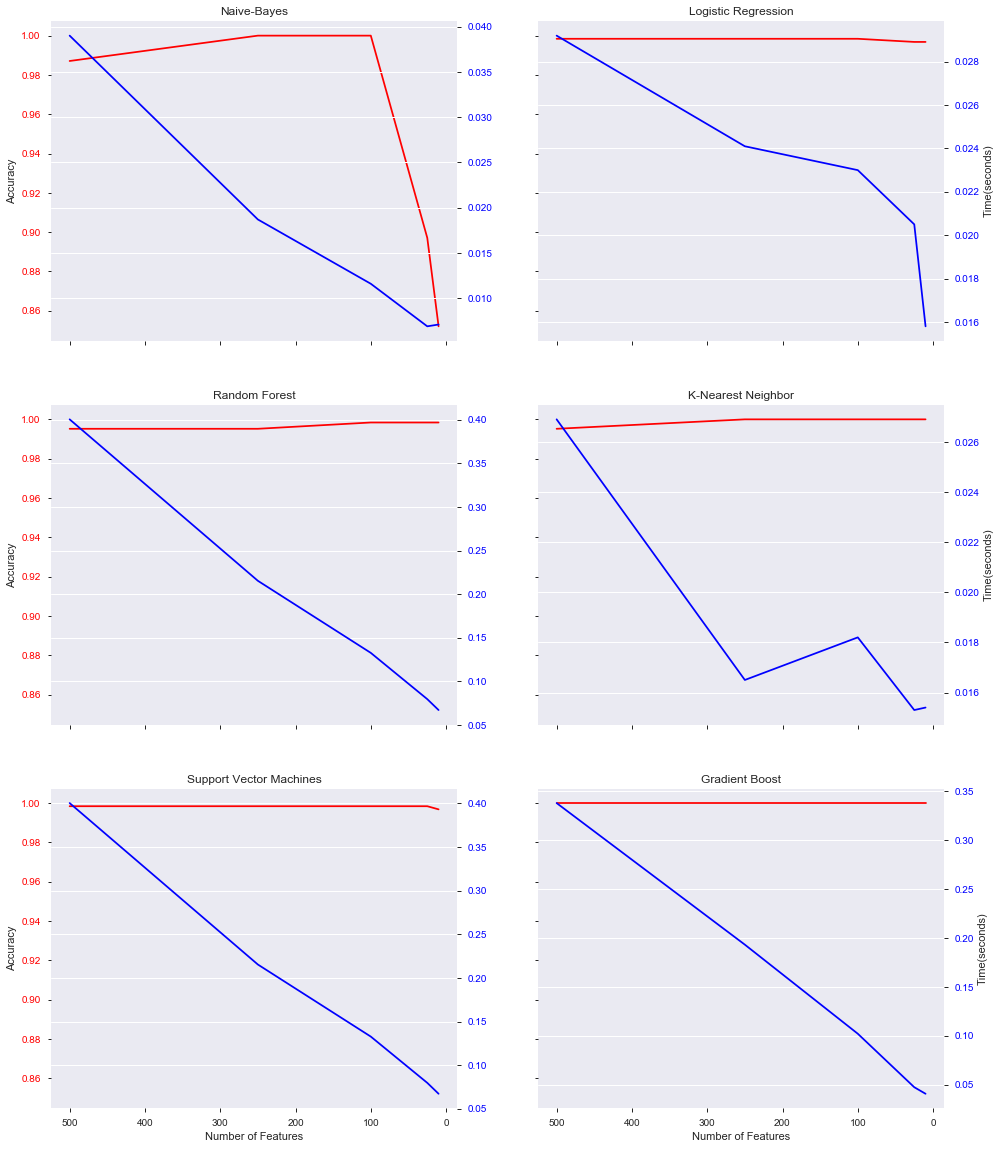

In [185]:
f, ax = plt.subplots(3, 2, figsize=(16, 20), sharex=True, sharey=True)

# Naive-Bayes
ax1 = ax[0, 0]
ax1.plot(nb_df['bow'], nb_df['test_score'], c='r')
ax1.tick_params(axis='y', labelcolor='r')

ax1a = ax1.twinx()
ax1a.plot(nb_df['bow'], nb_df['time_elapsed'], c='b')
ax1a.tick_params(axis='y', labelcolor='b')

ax1.set_ylabel('Accuracy')
ax1.invert_xaxis()
ax1.grid()
ax1.set_title('Naive-Bayes')

# Logistic Regression
ax2 = ax[0, 1]
ax2.plot(lr_df['bow'], lr_df['test_score'], c='r')
ax2.tick_params(axis='y', labelcolor='r')

ax2a = ax2.twinx()
ax2a.plot(lr_df['bow'], lr_df['time_elapsed'], c='b')
ax2a.tick_params(axis='y', labelcolor='b')
ax2a.set_ylabel('Time(seconds)')

ax2.grid()
ax2.set_title('Logistic Regression')

# Random Forest
ax3 = ax[1, 0]
ax3.plot(rf_df['bow'], rf_df['test_score'], c='r')
ax3.tick_params(axis='y', labelcolor='r')

ax3a = ax3.twinx()
ax3a.plot(rf_df['bow'], rf_df['time_elapsed'], c='b')
ax3a.tick_params(axis='y', labelcolor='b')

ax3.set_ylabel('Accuracy')
ax3.grid()
ax3.set_title('Random Forest')

# K-Nearest Neighbors
ax4 = ax[1, 1]
ax4.plot(knn_df['bow'], knn_df['test_score'], c='r')
ax4.tick_params(axis='y', labelcolor='r')

ax4a = ax4.twinx()
ax4a.plot(knn_df['bow'], knn_df['time_elapsed'], c='b')
ax4a.tick_params(axis='y', labelcolor='b')
ax4a.set_ylabel('Time(seconds)')

#ax4.invert_xaxis()
ax4.grid()
ax4.set_title('K-Nearest Neighbor')

# Support Vector Machines
ax5 = ax[2, 0]
ax5.plot(svm_df['bow'], svm_df['test_score'], c='r')
ax5.tick_params(axis='y', labelcolor='r')

ax5a = ax5.twinx()
ax5a.plot(rf_df['bow'], rf_df['time_elapsed'], c='b')
ax5a.tick_params(axis='y', labelcolor='b')

#ax5.invert_xaxis()
ax5.grid()
ax5.set_xlabel('Number of Features')
ax5.set_ylabel('Accuracy')
ax5.set_title('Support Vector Machines')

# Gradient Boost
ax6 = ax[2, 1]
ax6.plot(gb_df['bow'], gb_df['test_score'], c='r')
ax6.tick_params(axis='y', labelcolor='r')

ax6a = ax6.twinx()
ax6a.plot(gb_df['bow'], gb_df['time_elapsed'], c='b')
ax6a.tick_params(axis='y', labelcolor='b')
ax6a.set_ylabel('Time(seconds)')

#ax6.invert_xaxis()
ax6.grid()
ax6.set_xlabel('Number of Features')
ax6.set_title('Gradient Boost')

plt.show()

Looking at these plots, as the size of the bag of words decreases, naive-bayes, logistic regression, knn, and gradient boosting models all decrease in accuracy while the random forest and support vector classifiers slightly increase. Let's evaluate further.

In [186]:
# evaluation function
def evaluate(c_mat):
    # tp / (tp + fp)
    precision = c_mat[0, 0] / (c_mat[0, 0] + c_mat[1, 0])
    
    # tn / (tn + fn)
    recall = c_mat[1, 1] / (c_mat[1, 1] + c_mat[0, 1])
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1

In [187]:
# calculate scores
nb_prec, nb_rec, nb_f1 = evaluate(nb_cmat)
lr_prec, lr_rec, lr_f1 = evaluate(lr_cmat)
rf_prec, rf_rec, rf_f1 = evaluate(rf_cmat)
knn_prec, knn_rec, knn_f1 = evaluate(knn_cmat)
svm_prec, svm_rec, svm_f1 = evaluate(svm_cmat)
gb_prec, gb_rec, gb_f1 = evaluate(gb_cmat)

In [188]:
# let's start with the confusion matrices
print(f'Naive-Bayes:\n{nb_cmat}')
print(f'  Precision:{nb_prec}\n  Recall:   {nb_rec}\n  f1-score: {nb_f1}\n')

print(f'Logistic regression:\n{lr_cmat}')
print(f'  Precision:{lr_prec}\n  Recall:   {lr_rec}\n  f1-score: {lr_f1}\n')

print(f'Random forest:\n{rf_cmat}')
print(f'  Precision:{rf_prec}\n  Recall:   {rf_rec}\n  f1-score: {rf_f1}\n')

print(f'KNN:\n{knn_cmat}')
print(f'  Precision:{knn_prec}\n  Recall:   {knn_rec}\n  f1-score: {knn_f1}\n')

print(f'SVM:\n{svm_cmat}')
print(f'  Precision:{svm_prec}\n  Recall:   {svm_rec}\n  f1-score: {svm_f1}\n')

print(f'Gradient boost:\n{gb_cmat}')
print(f'  Precision:{gb_prec}\n  Recall:   {gb_rec}\n  f1-score: {gb_f1}\n')


Naive-Bayes:
[[251  64]
 [ 28 279]]
  Precision:0.899641577060932
  Recall:   0.8134110787172012
  f1-score: 0.8543560213256555

Logistic regression:
[[313   2]
 [  0 307]]
  Precision:1.0
  Recall:   0.9935275080906149
  f1-score: 0.9967532467532468

Random forest:
[[315   0]
 [  0 307]]
  Precision:1.0
  Recall:   1.0
  f1-score: 1.0

KNN:
[[314   1]
 [  0 307]]
  Precision:1.0
  Recall:   0.9967532467532467
  f1-score: 0.9983739837398374

SVM:
[[313   2]
 [  0 307]]
  Precision:1.0
  Recall:   0.9935275080906149
  f1-score: 0.9967532467532468

Gradient boost:
[[315   0]
 [  0 307]]
  Precision:1.0
  Recall:   1.0
  f1-score: 1.0



For our purposes, we want to minimize the false negatives, or jobs that are DS jobs but misclassified. That is to say, we want high recall numbers. But since all 6 models give us a perfect recall and f-1 score, let's use the model that gives us explainability. We have two models that fit this criteria but I'll go with random forest since it is most consistently good.

#### Random Forest Classifier Evaluation

In [191]:
# feature importance
fi = gb.feature_importances_
words = X10.columns
important_words = list(zip(fi, words))
important_words

[(0.0, 'datum'),
 (0.0, 'experience'),
 (0.0, 'work'),
 (0.0, 'data'),
 (0.0, 'team'),
 (0.0, 'learning'),
 (0.0, 'business'),
 (0.6818570610096732, 'machine'),
 (0.3181429389903267, 'analysis'),
 (0.0, 'skill')]

So... apparently the gradient boosting classifier only just needs two words: 'machine' and 'analysis'. Makes all of my work seem a bit pointless heheh.

### V. Make Predictions

So now that we have a model, let's apply the 'other' jobs to see how many can actually be classified as DS jobs.

In [199]:
# "Other" jobs
other_df = df[(df['ds'] == False) & (df['da'] == False)]
other_df.reset_index(drop=True, inplace=True)
other_df.head(5)

title  \
0                Data Entry Clerk   
1         Manager, Data Analytics   
2                   Data Engineer   
3  Evaluator, IT - Data Analytics   
4            Senior Data Engineer   

                                             company              location  \
0  I promote affiliate Marketing and how to make ...                         
1                                               Bird  Santa Monica, CA, US   
2                                            Clutter   Los Angeles, CA, US   
3                       Western Governors University   Los Angeles, CA, US   
4                          ReSci (Retention Science)  Santa Monica, CA, US   

                                                link           level  \
0  https://www.linkedin.com/jobs/view/data-entry-...  Not Applicable   
1  https://www.linkedin.com/jobs/view/manager-dat...       Associate   
2  https://www.linkedin.com/jobs/view/data-engine...     Entry level   
3  https://www.linkedin.com/jobs/view/evaluator-i...       Associate   
4  https://www.linkedin.com/jobs/view/senior-data...       Associate   

                                         description     ds     da  \
0  This opportunity is great and it really works....  False  False   
1  Who Is BirdAt Bird, we’re on a mission to make...  False  False   
2  Clutter is an on-demand storage and technology...  False  False   
3  If you’re passionate about building a better f...  False  False   
4  We are growing rapidly and looking for great e...  False  False   

                                              parsed  \
0  (this, opportunity, is, great, and, it, really...   
1  (who, is, birdat, bird, ,, we, ’re, on, a, mis...   
2  (clutter, is, an, on, demand, storage, and, te...   
3  (if, you, ’re, passionate, about, building, a,...   
4  (we, are, growing, rapidly, and, looking, for,...   

                                            filtered  
0  [opportunity, great, work, take, time, effort,...  
1  [birdat, bird, mission, city, livable, reduce,...  
2  [clutter, demand, storage, technology, company...  
3  [passionate, build, well, future, individual, ...  
4  [grow, rapidly, look, great, engineer, join, t...

In [200]:
other_ftr_10_df = bow_features(other_df, top10_bow)    # this should take a while

Processing row 0
Processing row 1000
Time elapsed: 118.12s


In [201]:
other_ftr_10_df.sample(5)

datum  experience  work  data  team  learning  business  machine  \
241       0           1     2     0     0         0         0        0   
1648      9           2     5     1     1         0         2        1   
565       0           1     1     1     0         0         1        0   
1321      1           4     2     0     1         0         0        0   
426       2           6     0     2     1         0         0        0   

      analysis  skill                                        description  \
241          0      1  (must, have, banking, ,, finance, ,, data, ent...   
1648         2      4  (about, wpromotehere, at, wpromote, ,, one, of...   
565          0      1  (job, description, as, the, reporting, analyst...   
1321         1      1  (the, matian, firm, ,, apc, dedicates, its, re...   
426          1      0  (we, are, seeking, a, senior, etl, developer, ...   

         ds     da  
241   False  False  
1648  False  False  
565   False  False  
1321  False  False  
426   False  False

In [202]:
X_other = other_ftr_10_df.drop(columns=['description', 'ds', 'da'])
y_other = other_ftr_10_df['ds']

# make predictions
y_pred_gb = gb.predict(X_other)
gb_cmat = confusion_matrix(y_other, y_pred_gb, labels=[True, False])
print(f'Random Forest:\n{gb_cmat}')


Random Forest:
[[   0    0]
 [ 398 1328]]


So close to 400 job listings in the 'maybe' category is classified as a DS job. That's great news. Let's take a look at some of them.

In [213]:
other_results = pd.DataFrame()
other_results['gb'] = y_pred_gb

other_results[other_results['gb']==True].sample(3)

gb
1314  True
198   True
1031  True

In [215]:
df.iloc[1314].link

'https://www.linkedin.com/jobs/view/data-analyst-at-ejento-1637079996?refId=3ac2ce4c-f295-4914-9714-f367de1cb500&position=15&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

In [216]:
df.iloc[198].link

'https://www.linkedin.com/jobs/view/data-operations-analyst-1-at-truecar-inc-1638054867?refId=a132f1bf-fae0-44e4-992e-0e59c45547bb&position=24&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

In [217]:
df.iloc[1031].link

'https://www.linkedin.com/jobs/view/data-analyst-at-3-phases-renewables-1529805984?refId=2d1ce7e5-13c2-4dbd-ac24-3748d021e4bd&position=7&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

Hmmmm... that's certainly interesting. These obviously contain the target phrase, yet were mis-classified. While it's concerning that the initial filtering didn't catch this listing, it's a positive that the gradient boosting model was able to correctly classify it in the end. Now let's look at some that were in the other class.

In [214]:
other_results[other_results['gb']==False].sample(3)

gb
1150  False
1385  False
914   False

In [218]:
df.iloc[1150].link

'https://www.linkedin.com/jobs/view/data-analyst-at-real-staffing-1609028983?refId=60963cda-c500-498e-b8e9-bee9e6e4d521&position=1&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

In [220]:
df.iloc[1385].link

'https://www.linkedin.com/jobs/view/senior-data-scientist-at-paramount-pictures-1599245783?refId=4b4d0064-01c7-4c06-a533-fa14ef9e4cd5&position=11&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

In [219]:
df.iloc[914].link

'https://www.linkedin.com/jobs/view/data-analyst-at-ejento-1637079996?refId=13fe4654-f27d-4b70-b038-6070b6cb7b64&position=15&pageNum=0&trk=guest_job_search_job-result-card_result-card_full-click'

### VI. Conclusion
So out of 3500 jobs listed, over 2100 jobs posted are either Data Science jobs or of closely related field. It looks like for the next few days, it will almost be a full time job just to apply to these jobs. Of course, there are ways to narrow the field down even more depending on the experience level desired and location. But for now, this exercise in web scraping and natural language processing to apply supervised learning algorithms enabled us to separate the wheat from the chaff. I was able to achieve over 95% accuracy by applying just a 10-word bag of words to the job description. I would say that this was a pretty successful, if not quite as in-depth, look into the job field as an entry-level data scientist.

I'm going to wrap this up by creating a couple of word clouds to display the most commonly used words in data science jobs vs other jobs.